In [15]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置seaborn样式
sns.set_style("whitegrid")

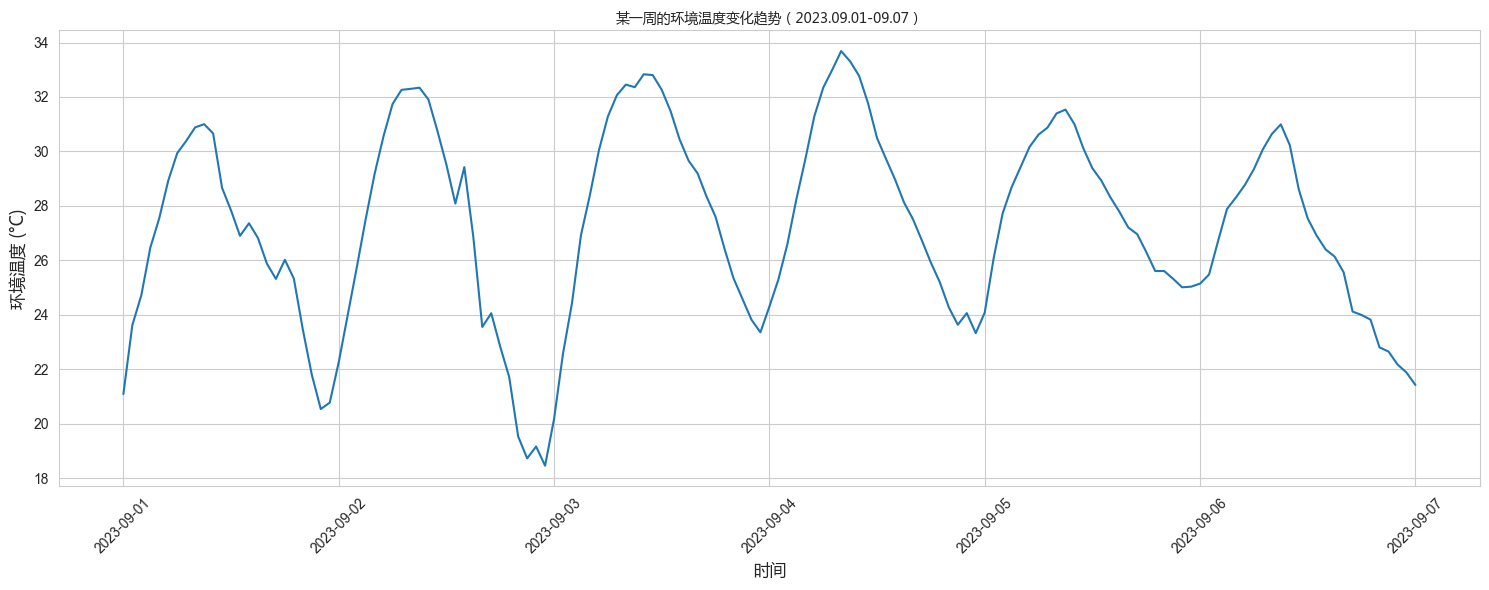

这一周的数据统计：
平均温度：27.27°C
最高温度：33.69°C
最低温度：18.46°C


In [16]:
# 读取按小时采样的数据
hourly_df = pd.read_csv('temperature_hourly.csv')

# 将时间列转换为datetime格式
hourly_df['时间'] = pd.to_datetime(hourly_df['时间'])

# 选择一周的数据（比如从2023-09-01开始的一周）
start_date = '2023-09-01'
end_date = '2023-09-07'
week_data = hourly_df[(hourly_df['时间'] >= start_date) & (hourly_df['时间'] <= end_date)]

# 创建图形
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# 绘制一周的温度变化曲线
plt.plot(week_data['时间'], week_data['环境温度'], linewidth=1.5)

# 设置标题和轴标签
plt.title('某一周的环境温度变化趋势（2023.09.01-09.07）', fontsize=14, fontproperties='Microsoft YaHei')
plt.xlabel('时间', fontsize=12, fontproperties='Microsoft YaHei')
plt.ylabel('环境温度 (°C)', fontsize=12, fontproperties='Microsoft YaHei')

# 旋转x轴标签
plt.xticks(rotation=45)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 打印这一周的基本统计信息
print(f"这一周的数据统计：")
print(f"平均温度：{week_data['环境温度'].mean():.2f}°C")
print(f"最高温度：{week_data['环境温度'].max():.2f}°C")
print(f"最低温度：{week_data['环境温度'].min():.2f}°C")

检查缺失值：
时间       0
环境温度    14
dtype: int64

训练数据大小: 5120
测试数据大小: 24


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



预测误差（MSE）：
Holt-Winters MSE: 14.19
SARIMAX MSE: 8.69


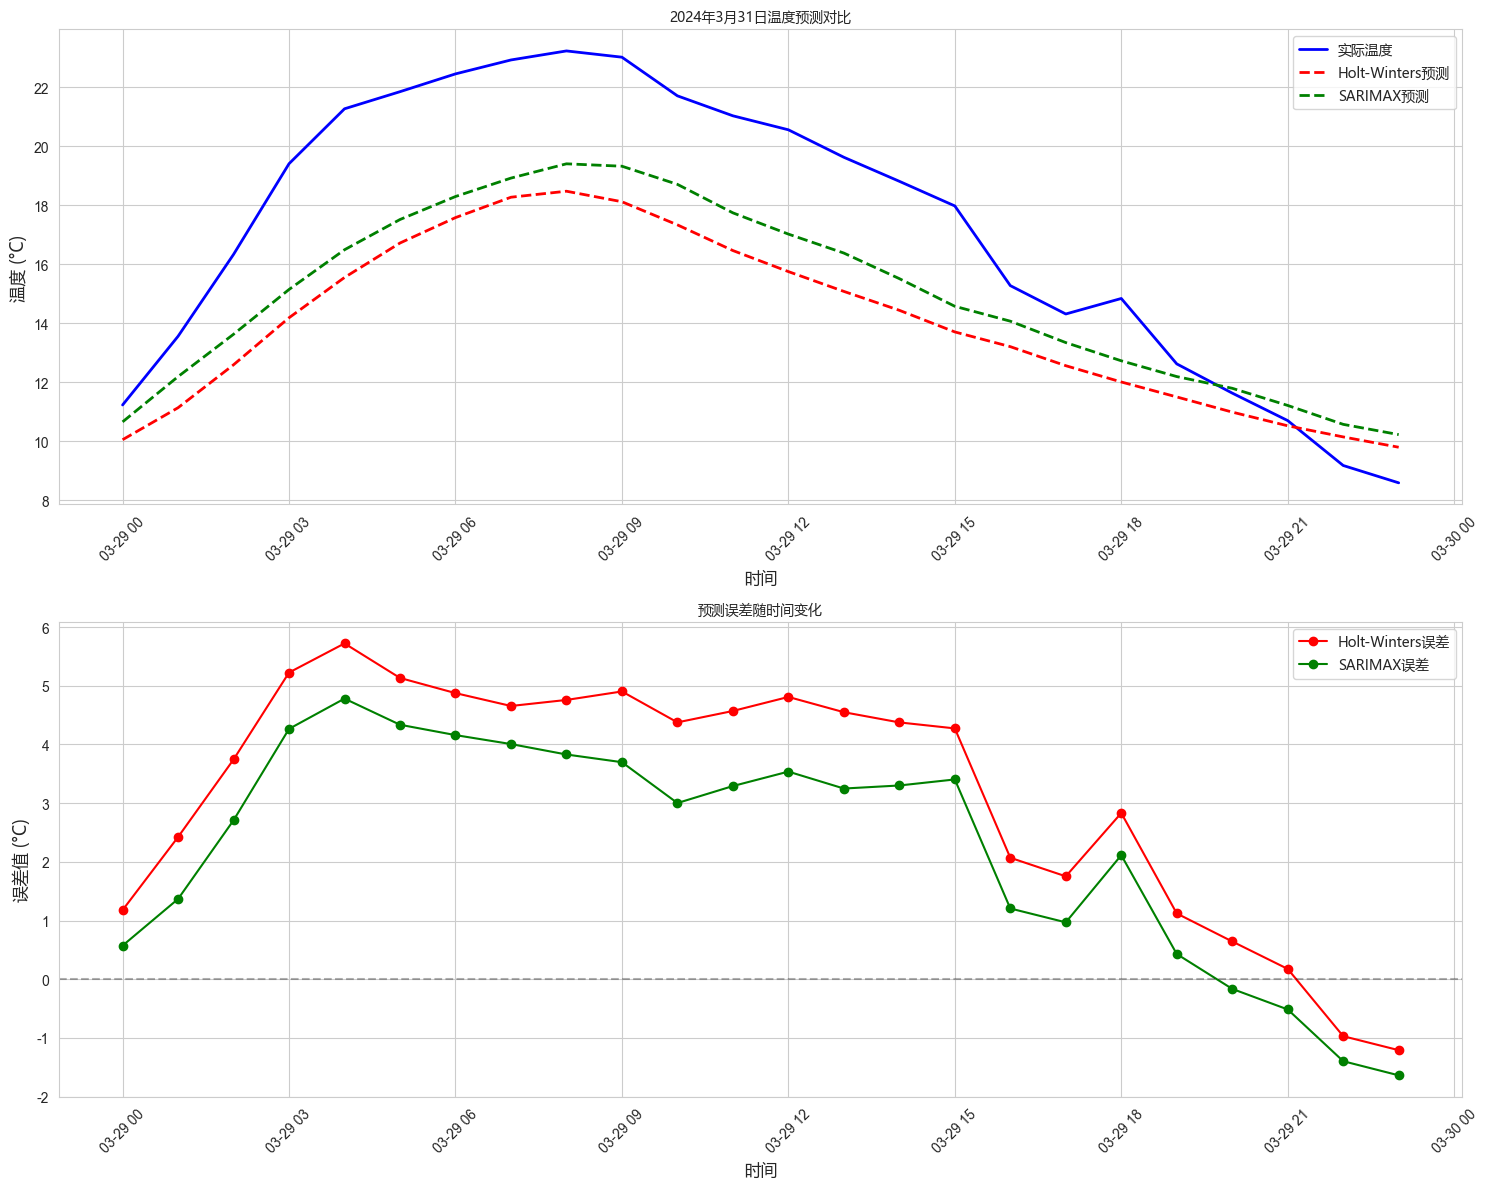


每小时预测误差：
                    时间  Holt-Winters误差  SARIMAX误差
0  2024-03-29 00:00:00        1.178759   0.573451
1  2024-03-29 01:00:00        2.423410   1.368241
2  2024-03-29 02:00:00        3.744028   2.708499
3  2024-03-29 03:00:00        5.225226   4.265773
4  2024-03-29 04:00:00        5.721267   4.781287
5  2024-03-29 05:00:00        5.133099   4.336016
6  2024-03-29 06:00:00        4.874864   4.159726
7  2024-03-29 07:00:00        4.655752   4.007065
8  2024-03-29 08:00:00        4.758558   3.829218
9  2024-03-29 09:00:00        4.903171   3.698154
10 2024-03-29 10:00:00        4.376491   3.002295
11 2024-03-29 11:00:00        4.570539   3.291824
12 2024-03-29 12:00:00        4.809642   3.537784
13 2024-03-29 13:00:00        4.549746   3.249416
14 2024-03-29 14:00:00        4.375814   3.301482
15 2024-03-29 15:00:00        4.273785   3.404222
16 2024-03-29 16:00:00        2.070070   1.206196
17 2024-03-29 17:00:00        1.753971   0.969938
18 2024-03-29 18:00:00        2.832130  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import concurrent.futures
from matplotlib.font_manager import FontProperties

# 设置中文字体显示
try:
    # 尝试使用微软雅黑
    font = FontProperties(fname=r'C:\Windows\Fonts\msyh.ttc')
except:
    try:
        # 尝试使用苹果系统的字体（对于MacOS用户）
        font = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')
    except:
        # 如果都失败了，使用系统默认字体
        font = FontProperties()

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def load_and_process_data(file_path):
    """加载和预处理数据"""
    # 读取数据
    df = pd.read_csv(file_path)
    df['时间'] = pd.to_datetime(df['时间'])
    
    print("检查缺失值：")
    print(df.isnull().sum())
    
    # 处理缺失值
    df['环境温度'] = df['环境温度'].fillna(method='ffill').fillna(method='bfill')
    
    # 设置时间索引
    df.set_index('时间', inplace=True)
    return df.sort_index()

def train_hw_model(train_data, test_length):
    """训练Holt-Winters模型"""
    model = ExponentialSmoothing(
        train_data,
        seasonal_periods=24,
        trend='add',
        seasonal='add',
        initialization_method='estimated'
    ).fit(optimized=True)
    
    return model.forecast(test_length)

def train_sarimax_model(train_data, test_length):
    """训练SARIMAX模型"""
    model = SARIMAX(
        train_data,
        order=(2, 1, 2),
        seasonal_order=(1, 1, 1, 24)
    ).fit(disp=False)
    
    return model.forecast(test_length)

def calculate_mse(actual, predicted):
    """计算均方误差"""
    return np.nanmean((actual - predicted) ** 2)

def main():
    # 加载数据
    df = load_and_process_data('temperature_hourly.csv')
    
    # 准备训练数据和测试数据
    train_end = '2024-03-28 23:00:00'
    test_start = '2024-03-29 00:00:00'
    test_end = '2024-03-29 23:00:00'
    
    train_data = df.loc[:train_end]['环境温度']
    test_data = df.loc[test_start:test_end]['环境温度']
    
    print("\n训练数据大小:", len(train_data))
    print("测试数据大小:", len(test_data))
    
    # 并行训练模型
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        # 提交训练任务
        hw_future = executor.submit(train_hw_model, train_data, len(test_data))
        sarimax_future = executor.submit(train_sarimax_model, train_data, len(test_data))
        
        # 获取预测结果
        hw_forecast = hw_future.result()
        sarimax_forecast = sarimax_future.result()
    
    # 并行计算MSE
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        hw_mse_future = executor.submit(calculate_mse, test_data.values, hw_forecast.values)
        sarimax_mse_future = executor.submit(calculate_mse, test_data.values, sarimax_forecast.values)
        
        hw_mse = hw_mse_future.result()
        sarimax_mse = sarimax_mse_future.result()
    
    # 打印预测误差
    print("\n预测误差（MSE）：")
    print(f"Holt-Winters MSE: {hw_mse:.2f}")
    print(f"SARIMAX MSE: {sarimax_mse:.2f}")
    
    # 计算误差
    hw_errors = test_data.values - hw_forecast.values
    sarimax_errors = test_data.values - sarimax_forecast.values

    # 创建每小时误差的数据框
    hourly_errors = pd.DataFrame({
        '时间': test_data.index,
        'Holt-Winters误差': hw_errors,
        'SARIMAX误差': sarimax_errors
    })

    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # 第一个子图：预测结果
    ax1.plot(test_data.index, test_data.values, 
             label='实际温度', linewidth=2, color='blue')
    ax1.plot(test_data.index, hw_forecast.values, 
             label='Holt-Winters预测', linewidth=2, linestyle='--', color='red')
    ax1.plot(test_data.index, sarimax_forecast.values, 
             label='SARIMAX预测', linewidth=2, linestyle='--', color='green')

    ax1.set_title('2024年3月31日温度预测对比', fontsize=14, fontproperties=font)
    ax1.set_xlabel('时间', fontsize=12, fontproperties=font)
    ax1.set_ylabel('温度 (°C)', fontsize=12, fontproperties=font)
    ax1.legend(fontsize=10, prop=font)
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # 第二个子图：误差值
    ax2.plot(hourly_errors['时间'], hourly_errors['Holt-Winters误差'], 
             label='Holt-Winters误差', color='red', marker='o')
    ax2.plot(hourly_errors['时间'], hourly_errors['SARIMAX误差'], 
             label='SARIMAX误差', color='green', marker='o')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

    ax2.set_title('预测误差随时间变化', fontsize=14, fontproperties=font)
    ax2.set_xlabel('时间', fontsize=12, fontproperties=font)
    ax2.set_ylabel('误差值 (°C)', fontsize=12, fontproperties=font)
    ax2.legend(fontsize=10, prop=font)
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 打印每小时的误差值
    print("\n每小时预测误差：")
    print(hourly_errors.to_string())

    # 计算误差统计指标
    print("\n误差统计：")
    for model in ['Holt-Winters', 'SARIMAX']:
        errors = hourly_errors[f'{model}误差']
        print(f"\n{model}模型：")
        print(f"平均误差 (ME): {errors.mean():.2f}")
        print(f"平均绝对误差 (MAE): {abs(errors).mean():.2f}")
        print(f"均方误差 (MSE): {(errors**2).mean():.2f}")
        print(f"均方根误差 (RMSE): {np.sqrt((errors**2).mean()):.2f}")

if __name__ == "__main__":
    main() 

检查缺失值：
时间       0
环境温度    14
dtype: int64

数据统计信息：
训练数据范围: 2024-02-01 00:00:00 至 2024-03-28 23:00:00
测试数据范围: 2024-03-29 00:00:00 至 2024-03-29 23:00:00
训练数据最小值: -15.168333333333331
训练数据最大值: 21.808
测试数据最小值: 8.586166666666665
测试数据最大值: 23.2365


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



预测误差（MSE）：
Holt-Winters MSE: 11.83
SARIMAX MSE: 7.24


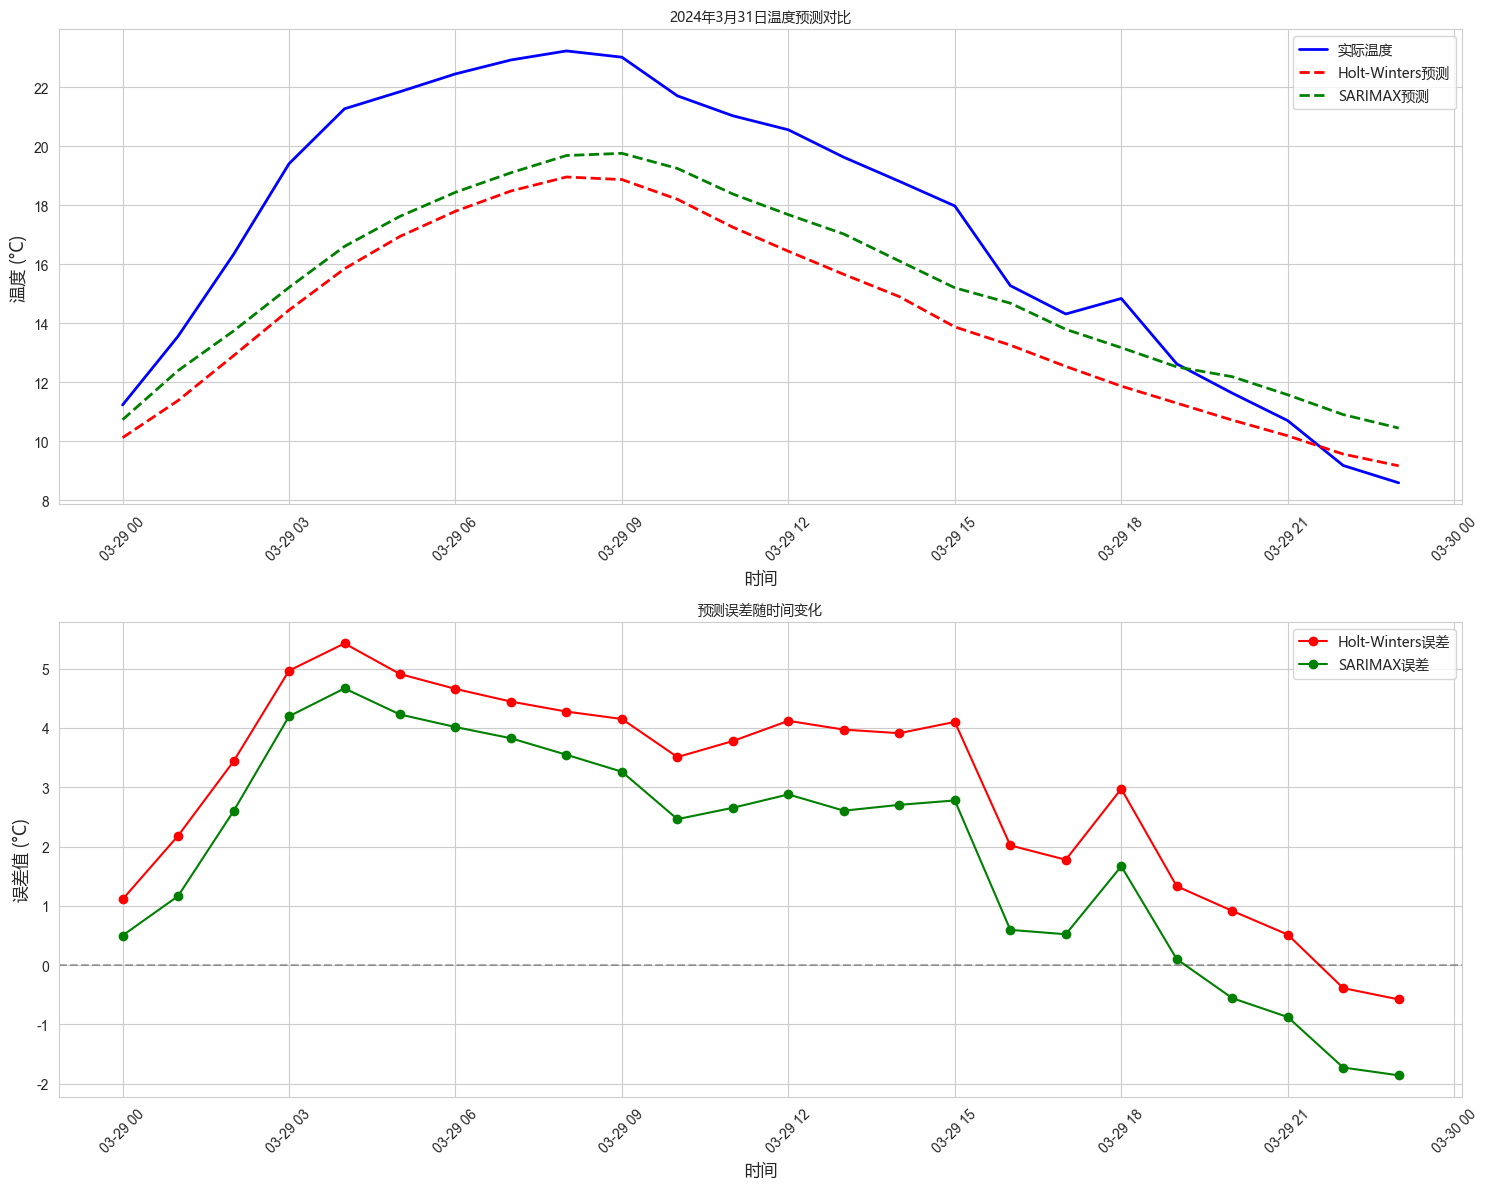


每小时预测误差：
                    时间  Holt-Winters误差  SARIMAX误差
0  2024-03-29 00:00:00        1.110061   0.499671
1  2024-03-29 01:00:00        2.181118   1.164673
2  2024-03-29 02:00:00        3.436362   2.597136
3  2024-03-29 03:00:00        4.966009   4.196796
4  2024-03-29 04:00:00        5.425263   4.666679
5  2024-03-29 05:00:00        4.909084   4.227132
6  2024-03-29 06:00:00        4.658413   4.015288
7  2024-03-29 07:00:00        4.444550   3.825928
8  2024-03-29 08:00:00        4.276032   3.547668
9  2024-03-29 09:00:00        4.150975   3.261327
10 2024-03-29 10:00:00        3.509000   2.461930
11 2024-03-29 11:00:00        3.779116   2.653641
12 2024-03-29 12:00:00        4.119610   2.879018
13 2024-03-29 13:00:00        3.971970   2.604758
14 2024-03-29 14:00:00        3.911371   2.703092
15 2024-03-29 15:00:00        4.102197   2.777278
16 2024-03-29 16:00:00        2.019009   0.594919
17 2024-03-29 17:00:00        1.777435   0.520650
18 2024-03-29 18:00:00        2.973045  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import concurrent.futures
from matplotlib.font_manager import FontProperties

# 设置中文字体显示
try:
    # 尝试使用微软雅黑
    font = FontProperties(fname=r'C:\Windows\Fonts\msyh.ttc')
except:
    try:
        # 尝试使用苹果系统的字体（对于MacOS用户）
        font = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')
    except:
        # 如果都失败了，使用系统默认字体
        font = FontProperties()

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def load_and_process_data(file_path):
    """加载和预处理数据"""
    # 读取数据
    df = pd.read_csv(file_path)
    df['时间'] = pd.to_datetime(df['时间'])
    
    print("检查缺失值：")
    print(df.isnull().sum())
    
    # 处理缺失值
    df['环境温度'] = df['环境温度'].fillna(method='ffill').fillna(method='bfill')
    
    # 设置时间索引
    df.set_index('时间', inplace=True)
    return df.sort_index()

def train_hw_model(train_data, test_length):
    """训练Holt-Winters模型"""
    # 检查数据是否都为正值
    min_temp = train_data.min()
    if min_temp <= 0:
        # 如果有非正值，将所有数据平移使其为正
        offset = abs(min_temp) + 1
        adjusted_data = train_data + offset
    else:
        adjusted_data = train_data
        offset = 0

    # 调整参数以提高预测精度
    model = ExponentialSmoothing(
        adjusted_data,
        seasonal_periods=24,  # 24小时周期
        trend='add',
        seasonal='add',
        damped_trend=True,    # 添加阻尼趋势
        use_boxcox=True,      # 在初始化时设置 Box-Cox 转换
        initialization_method='estimated'
    ).fit(
        optimized=True,
        remove_bias=True      # 移除偏差
    )
    
    # 预测后需要减去之前加上的偏移量
    forecast = model.forecast(test_length)
    if offset > 0:
        forecast = forecast - offset
    
    return forecast

def train_sarimax_model(train_data, test_length):
    """训练SARIMAX模型"""
    # 优化SARIMAX模型参数
    model = SARIMAX(
        train_data,
        order=(3, 1, 3),           # 简化ARIMA参数
        seasonal_order=(1, 1, 2, 24),  # 保持24小时季节性
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)  # 添加 low_memory=True 来减少内存使用
    
    return model.forecast(test_length)

def calculate_mse(actual, predicted):
    """计算均方误差"""
    return np.nanmean((actual - predicted) ** 2)

def main():
    # 加载数据
    df = load_and_process_data('temperature_hourly.csv')
    
    # 确保使用3月31日的数据
    train_start = '2024-02-01 00:00:00'
    train_end = '2024-03-28 23:00:00'
    test_start = '2024-03-29 00:00:00'
    test_end = '2024-03-29 23:00:00'
    
    train_data = df.loc[train_start:train_end]['环境温度']
    test_data = df.loc[test_start:test_end]['环境温度']
    
    print("\n数据统计信息：")
    print("训练数据范围:", train_data.index[0], "至", train_data.index[-1])
    print("测试数据范围:", test_data.index[0], "至", test_data.index[-1])
    print("训练数据最小值:", train_data.min())
    print("训练数据最大值:", train_data.max())
    print("测试数据最小值:", test_data.min())
    print("测试数据最大值:", test_data.max())
    
    # 并行训练模型
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        # 提交训练任务
        hw_future = executor.submit(train_hw_model, train_data, len(test_data))
        sarimax_future = executor.submit(train_sarimax_model, train_data, len(test_data))
        
        # 获取预测结果
        hw_forecast = hw_future.result()
        sarimax_forecast = sarimax_future.result()
    
    # 并行计算MSE
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        hw_mse_future = executor.submit(calculate_mse, test_data.values, hw_forecast.values)
        sarimax_mse_future = executor.submit(calculate_mse, test_data.values, sarimax_forecast.values)
        
        hw_mse = hw_mse_future.result()
        sarimax_mse = sarimax_mse_future.result()
    
    # 打印预测误差
    print("\n预测误差（MSE）：")
    print(f"Holt-Winters MSE: {hw_mse:.2f}")
    print(f"SARIMAX MSE: {sarimax_mse:.2f}")
    
    # 计算误差
    hw_errors = test_data.values - hw_forecast.values
    sarimax_errors = test_data.values - sarimax_forecast.values

    # 创建每小时误差的数据框
    hourly_errors = pd.DataFrame({
        '时间': test_data.index,
        'Holt-Winters误差': hw_errors,
        'SARIMAX误差': sarimax_errors
    })

    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # 第一个子图：预测结果
    ax1.plot(test_data.index, test_data.values, 
             label='实际温度', linewidth=2, color='blue')
    ax1.plot(test_data.index, hw_forecast.values, 
             label='Holt-Winters预测', linewidth=2, linestyle='--', color='red')
    ax1.plot(test_data.index, sarimax_forecast.values, 
             label='SARIMAX预测', linewidth=2, linestyle='--', color='green')

    ax1.set_title('2024年3月31日温度预测对比', fontsize=14, fontproperties=font)
    ax1.set_xlabel('时间', fontsize=12, fontproperties=font)
    ax1.set_ylabel('温度 (°C)', fontsize=12, fontproperties=font)
    ax1.legend(fontsize=10, prop=font)
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # 第二个子图：误差值
    ax2.plot(hourly_errors['时间'], hourly_errors['Holt-Winters误差'], 
             label='Holt-Winters误差', color='red', marker='o')
    ax2.plot(hourly_errors['时间'], hourly_errors['SARIMAX误差'], 
             label='SARIMAX误差', color='green', marker='o')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

    ax2.set_title('预测误差随时间变化', fontsize=14, fontproperties=font)
    ax2.set_xlabel('时间', fontsize=12, fontproperties=font)
    ax2.set_ylabel('误差值 (°C)', fontsize=12, fontproperties=font)
    ax2.legend(fontsize=10, prop=font)
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 打印每小时的误差值
    print("\n每小时预测误差：")
    print(hourly_errors.to_string())

    # 计算误差统计指标
    print("\n误差统计：")
    for model in ['Holt-Winters', 'SARIMAX']:
        errors = hourly_errors[f'{model}误差']
        print(f"\n{model}模型：")
        print(f"平均误差 (ME): {errors.mean():.2f}")
        print(f"平均绝对误差 (MAE): {abs(errors).mean():.2f}")
        print(f"均方误差 (MSE): {(errors**2).mean():.2f}")
        print(f"均方根误差 (RMSE): {np.sqrt((errors**2).mean()):.2f}")

    # 在打印误差统计之前添加预测值的输出
    print("\n预测值与实际值对比：")
    comparison_df = pd.DataFrame({
        '实际温度': test_data,
        'Holt-Winters预测': hw_forecast,
        'SARIMAX预测': sarimax_forecast,
        'HW误差': hw_errors,
        'SARIMAX误差': sarimax_errors
    })
    print(comparison_df.round(2))  # 保留两位小数

    # 添加每个小时的相对误差百分比
    print("\n相对误差百分比：")
    relative_errors = pd.DataFrame({
        'HW相对误差(%)': (hw_errors / test_data.values) * 100,
        'SARIMAX相对误差(%)': (sarimax_errors / test_data.values) * 100
    }, index=test_data.index)
    print(relative_errors.round(2))  # 保留两位小数

if __name__ == "__main__":
    main() 

Before filling missing values:
环境温度    14
dtype: int64
After filling missing values:
环境温度    0
dtype: int64


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22659 (\N{CJK UNIFIED IDEOGRAPH-5883}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) Arial.
  fig.canvas

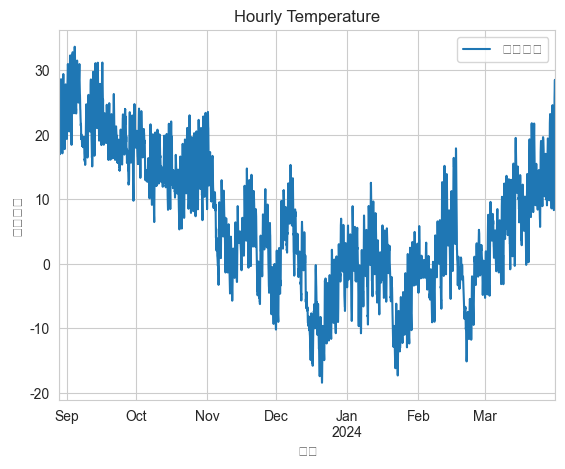

d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from font(s) Arial.
  fig.tight_layout()
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning: Glyph 22659 (\N{CJK UNIFIED IDEOGRAPH-5883}) missing from font(s) Arial.
  fig.tight_layout()
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) Arial.
  fig.tight_layout()
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.tight_layout()
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPyt

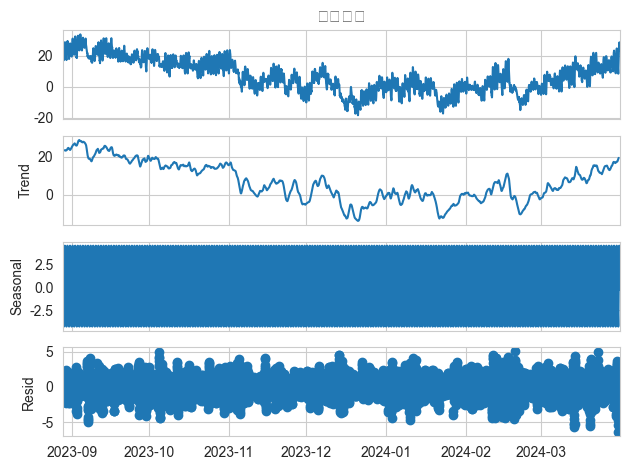

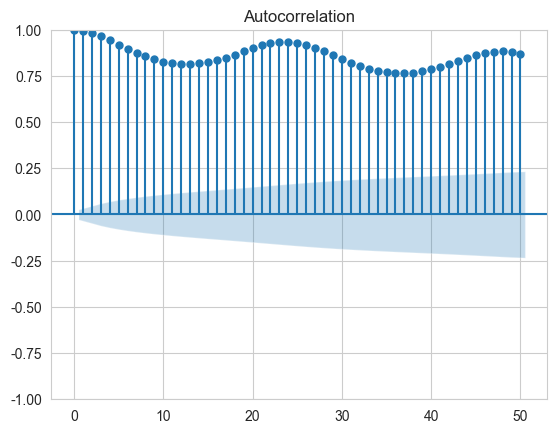

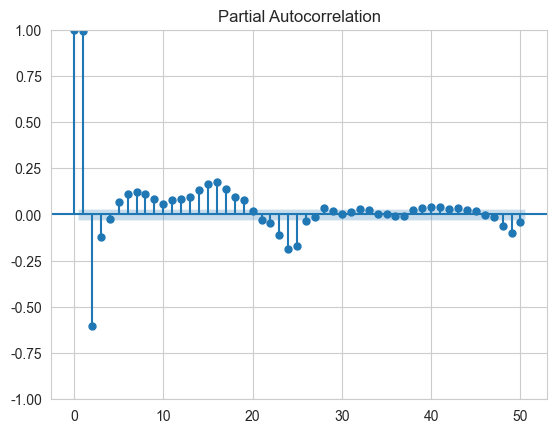

                          环境温度
时间                            
2023-08-28 16:00:00  24.457500
2023-08-28 17:00:00  20.516000
2023-08-28 18:00:00  18.761500
2023-08-28 19:00:00  19.178500
2023-08-28 20:00:00  18.277667


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 设置中文字体显示
try:
    # 尝试使用微软雅黑
    font = FontProperties(fname=r'C:\Windows\Fonts\msyh.ttc')
except:
    try:
        # 尝试使用苹果系统的字体（对于MacOS用户）
        font = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')
    except:
        # 如果都失败了，使用系统默认字体
        font = FontProperties()
# 读取数据
data = pd.read_csv('temperature_hourly.csv', parse_dates=['时间'], index_col='时间')

# 检查空值并填充空值，选择前向填充（ffill）或线性插值（interpolate）
print("Before filling missing values:")
print(data.isnull().sum())

# 使用前向填充（ffill）填充空值，或者你也可以选择插值
data['环境温度'] = data['环境温度'].fillna(method='ffill')
# data['环境温度'] = data['环境温度'].interpolate()

# 检查空值是否已填充
print("After filling missing values:")
print(data.isnull().sum())

# 绘制温度数据图
data.plot()
plt.title('Hourly Temperature')
plt.xlabel('时间')
plt.ylabel('环境温度')
plt.show()

# 季节性分解
# 假设季节性周期为24小时
result = seasonal_decompose(data['环境温度'], model='additive', period=24)
result.plot()
plt.show()

# 绘制自相关图（ACF）和偏自相关图（PACF）
plot_acf(data['环境温度'], lags=50)
plot_pacf(data['环境温度'], lags=50)
plt.show()

# 打印部分数据，观察时间序列
print(data.head())
 

d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22659 (\N{CJK UNIFIED IDEOGRAPH-5883}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from fon

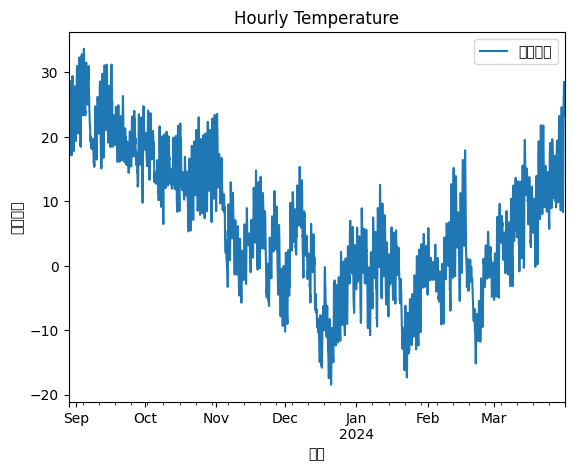

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  


Best parameters: (3, 1, 3, 1, 1, 2)
Best AIC: 10471.974039693634


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Final Model Summary:
                                        SARIMAX Results                                        
Dep. Variable:                                    环境温度   No. Observations:                 5184
Model:             SARIMAX(3, 1, 3)x(1, 1, [1, 2], 24)   Log Likelihood               -5225.995
Date:                                 Fri, 06 Dec 2024   AIC                          10471.990
Time:                                         11:57:04   BIC                          10537.374
Sample:                                     08-28-2023   HQIC                         10494.882
                                          - 03-31-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8781      0.076     24.639      0.0

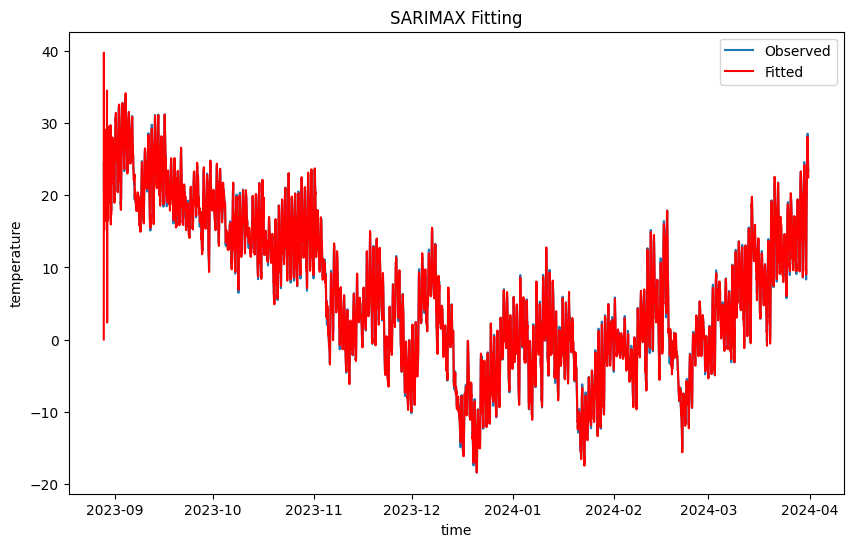

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# 读取数据
data = pd.read_csv('temperature_hourly.csv', parse_dates=['时间'], index_col='时间')

# 填充空值，使用前向填充
data['环境温度'] = data['环境温度'].fillna(method='ffill')

# 绘制数据
data.plot()
plt.title('Hourly Temperature')
plt.xlabel('时间')
plt.ylabel('环境温度')
plt.show()

# 设置季节性周期，这里假设为24小时
seasonal_period = 24

# 定义一个函数来进行SARIMAX模型训练和评估AIC
def evaluate_sarimax(p, d, q, P, D, Q, s):
    try:
        model = SARIMAX(data['环境温度'], 
                        order=(p, d, q),  # 非季节性部分
                        seasonal_order=(P, D, Q, s),  # 季节性部分
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        # 拟合模型
        results = model.fit(disp=False)
        
        # 返回AIC值和当前参数
        return (p, d, q, P, D, Q, results.aic)
    except:
        return (p, d, q, P, D, Q, np.inf)  # 如果模型拟合失败，返回一个很大的AIC值

# 定义更大的网格搜索的参数范围
p_values = [0, 1, 2, 3]  # 自回归阶数，增加到3
d_values = [0, 1]        # 差分阶数
q_values = [0, 1, 2, 3]  # 滑动平均阶数，增加到3
P_values = [0, 1, 2]     # 季节性自回归阶数，增加到2
D_values = [0, 1]        # 季节性差分阶数
Q_values = [0, 1, 2]     # 季节性滑动平均阶数，增加到2
seasonal_period = 24     # 季节性周期为24小时

# 使用joblib的Parallel和delayed进行并行计算
results = Parallel(n_jobs=-1, verbose=10)(delayed(evaluate_sarimax)(p, d, q, P, D, Q, seasonal_period)
                                           for p in p_values
                                           for d in d_values
                                           for q in q_values
                                           for P in P_values
                                           for D in D_values
                                           for Q in Q_values)

# 从计算结果中提取最佳AIC值和对应的参数
best_result = min(results, key=lambda x: x[6])  # 选择AIC最小的结果
best_p, best_d, best_q, best_P, best_D, best_Q, best_aic = best_result

# 输出最优参数
print("\nBest parameters:", (best_p, best_d, best_q, best_P, best_D, best_Q))
print("Best AIC:", best_aic)

# 使用最佳参数拟合最终的SARIMAX模型
final_model = SARIMAX(data['环境温度'], 
                      order=(best_p, best_d, best_q), 
                      seasonal_order=(best_P, best_D, best_Q, seasonal_period),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_results = final_model.fit(disp=False)

# 输出最终模型的摘要
print("\nFinal Model Summary:")
print(final_results.summary())

# 绘制拟合的结果
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['环境温度'], label='Observed')
plt.plot(final_results.fittedvalues.index, final_results.fittedvalues, label='Fitted', color='red')
plt.title('SARIMAX Fitting')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will b

Best SARIMAX parameters: ((3, 1, 3), (1, 1, 2, 24))


d:\CODE\Anaconda\envs\dlven\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Holt-Winters MSE: 14.19
SARIMAX MSE: 7.56
Holt-Winters误差较大，尝试其他方法...
SARIMAX误差较大，尝试其他方法...


C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Li\AppData\Local\Temp\ipykernel_21788\1791247145.py:130: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing fro

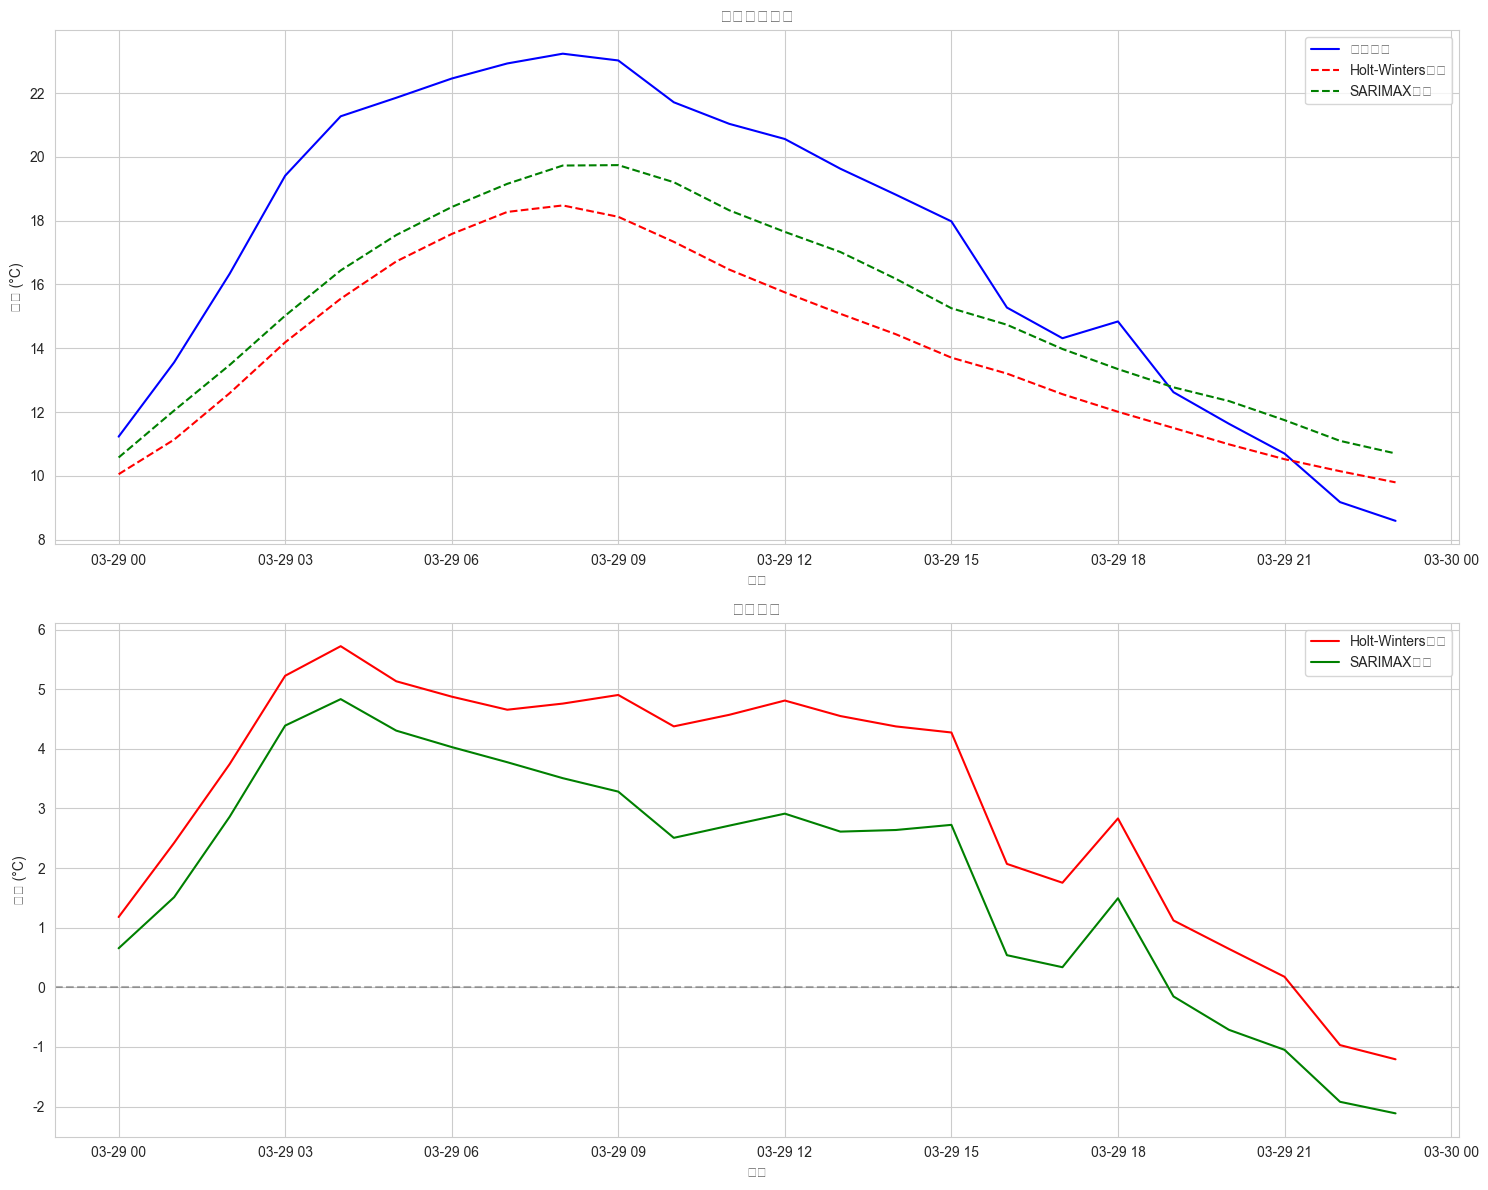

In [4]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import concurrent.futures
from sklearn.model_selection import GridSearchCV

def load_and_process_data(file_path):
    """加载和预处理数据"""
    df = pd.read_csv(file_path)
    df['时间'] = pd.to_datetime(df['时间'])
    df.set_index('时间', inplace=True)
    df['环境温度'] = df['环境温度'].fillna(method='ffill').fillna(method='bfill')
    return df

def train_hw_model(train_data, test_length, seasonal_periods=24):
    """训练Holt-Winters模型"""
    model = ExponentialSmoothing(
        train_data,
        seasonal_periods=seasonal_periods,
        trend='add',
        seasonal='add',
        initialization_method='estimated'
    ).fit(optimized=True)
    
    return model.forecast(test_length)

def train_sarimax_model(train_data, test_length, order=(2,1,2), seasonal_order=(1,1,1,24)):
    """训练SARIMAX模型"""
    model = SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order
    ).fit(disp=False)
    
    return model.forecast(test_length)

def tune_sarimax(train_data, param_grid, test_length):
    """网格搜索调优SARIMAX模型"""
    best_aic = np.inf
    best_model = None
    best_params = None
    
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            try:
                result = model.fit(disp=False)
                aic = result.aic
                if aic < best_aic:
                    best_aic = aic
                    best_model = result
                    best_params = (order, seasonal_order)
            except:
                continue
    return best_model, best_params

def calculate_mse(actual, predicted):
    """计算均方误差"""
    return mean_squared_error(actual, predicted)

def main():
    # 加载数据
    df = load_and_process_data('temperature_hourly.csv')
    
    # 准备训练数据和测试数据
    train_end = '2024-03-28 23:00:00'
    test_start = '2024-03-29 00:00:00'
    test_end = '2024-03-29 23:00:00'
    
    train_data = df.loc[:train_end]['环境温度']
    test_data = df.loc[test_start:test_end]['环境温度']
    
    # 网格搜索调优SARIMAX模型
    param_grid = {
        'order': [(1, 1, 1), (2, 1, 2), (3, 1, 3)],
        'seasonal_order': [(1, 1, 1, 24), (1, 1, 2, 24), (2, 1, 1, 24)]
    }
    
    sarimax_model, best_params = tune_sarimax(train_data, param_grid, len(test_data))
    print(f"Best SARIMAX parameters: {best_params}")
    
    # 使用Holt-Winters进行预测
    hw_forecast = train_hw_model(train_data, len(test_data))
    
    # 使用SARIMAX进行预测
    sarimax_forecast = sarimax_model.forecast(len(test_data))
    
    # 计算误差
    hw_mse = calculate_mse(test_data, hw_forecast)
    sarimax_mse = calculate_mse(test_data, sarimax_forecast)
    
    print(f"Holt-Winters MSE: {hw_mse:.2f}")
    print(f"SARIMAX MSE: {sarimax_mse:.2f}")
    
    # 如果MSE不满足2°C误差目标，进一步调整模型
    
    if hw_mse > 4:  # 假设4°C是误差的容忍度
        print("Holt-Winters误差较大，尝试其他方法...")
    
    if sarimax_mse > 4:
        print("SARIMAX误差较大，尝试其他方法...")

    # 绘制预测和误差图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 第一个子图：预测结果
    ax1.plot(test_data.index, test_data.values, label='实际温度', color='blue')
    ax1.plot(test_data.index, hw_forecast, label='Holt-Winters预测', linestyle='--', color='red')
    ax1.plot(test_data.index, sarimax_forecast, label='SARIMAX预测', linestyle='--', color='green')
    ax1.set_title('温度预测对比')
    ax1.set_xlabel('时间')
    ax1.set_ylabel('温度 (°C)')
    ax1.legend()
    ax1.grid(True)
    
    # 第二个子图：误差图
    ax2.plot(test_data.index, test_data - hw_forecast, label='Holt-Winters误差', color='red')
    ax2.plot(test_data.index, test_data - sarimax_forecast, label='SARIMAX误差', color='green')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_title('预测误差')
    ax2.set_xlabel('时间')
    ax2.set_ylabel('误差 (°C)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
